In [1]:
dfCrime = read.csv("crime_v2.csv")

In [2]:
summary(dfCrime)

     county           year        crmrte             prbarr       
 Min.   :  1.0   Min.   :87   Min.   :0.005533   Min.   :0.09277  
 1st Qu.: 52.0   1st Qu.:87   1st Qu.:0.020927   1st Qu.:0.20568  
 Median :105.0   Median :87   Median :0.029986   Median :0.27095  
 Mean   :101.6   Mean   :87   Mean   :0.033400   Mean   :0.29492  
 3rd Qu.:152.0   3rd Qu.:87   3rd Qu.:0.039642   3rd Qu.:0.34438  
 Max.   :197.0   Max.   :87   Max.   :0.098966   Max.   :1.09091  
 NA's   :6       NA's   :6    NA's   :6          NA's   :6        
        prbconv      prbpris           avgsen           polpc         
            : 5   Min.   :0.1500   Min.   : 5.380   Min.   :0.000746  
 0.588859022: 2   1st Qu.:0.3648   1st Qu.: 7.340   1st Qu.:0.001231  
 `          : 1   Median :0.4234   Median : 9.100   Median :0.001485  
 0.068376102: 1   Mean   :0.4108   Mean   : 9.647   Mean   :0.001702  
 0.140350997: 1   3rd Qu.:0.4568   3rd Qu.:11.420   3rd Qu.:0.001877  
 0.154451996: 1   Max.   :0.6000   Max

In [3]:
unique(dfCrime$prbconv)

[1] 0.527595997 1.481480002 0.267856985 0.525424004 0.476563007 0.068376102
 [7] 0.520606995 0.769231021 0.436441004 1.225610018 0.334701002 0.403780013
[13] 0.406780005 0.352941006 0.515464008 0.325300992 0.385495991 0.972972989
[19] 0.452829987 0.450567007 0.763333023 0.371879011 0.259833008 0.140350997
[25] 0.207830995 0.736908972 0.62251699  0.493438005 0.459215999 0.154451996
[31] 0.248275995 0.739394009 0.229589999 0.528302014 0.308411002 0.203724995
[37] 0.457210004 0.549019992 0.548494995 0.386925995 0.589905024 0.573943973
[43] 0.595077991 1.234380007 0.571429014 0.384236008 0.364353001 0.781608999
[49] 0.522387981 0.220339    1.5         0.793232977 0.347799987 0.226361006
[55] 0.438960999 1.358139992 0.393413007 0.495575011 0.271946996 0.477732986
[61] 1.068969965 0.28947401  0.412698001 0.314606994 0.340490997 0.426777989
[67] 1.015380025 0.36015299  0.520709991 0.559822977 0.443681002 0.492940009
[73] 0.50819701  0.401198    0.468531013 0.322580993 0.722972989 0.909090996
[79] 0.327868998 0.410596013 0.328664005 0.343023002 0.381908    2.121210098
[85] 0.443114012 0.300577998 0.449999988 0.588859022 1.670519948 1.182929993
[91]             `          
92 Levels:  ` 0.068376102 0.140350997 0.154451996 0.203724995 ... 2.121210098

In [4]:
library(survey)
library(effsize)
library(dplyr)
library(ggplot2)
library(tableone)

Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
dfCrime <-na.omit(dfCrime)

In [6]:
dfCrime <- dfCrime[!duplicated(dfCrime),]

In [7]:
dfCrime$prbconv<-as.numeric(levels(dfCrime$prbconv))[dfCrime$prbconv]

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [8]:
dfCrime$county<-as.factor(dfCrime$county) #note that we're missing 10 counties from NC; 6 were blank rows in this set, one row was a duplicate

In [9]:
dfCrime$pctmin80<-dfCrime$pctmin80/100 # units are off in comparison to pctymle; we either divide by 100 here or multiply the other one

In [10]:
#Map central and west to a region code. county 71 has both western and central codes
dfCrime$region <- case_when (
            (dfCrime$central ==0 & dfCrime$west ==0) ~ 0, #Eastern, Coastal, Other
            (dfCrime$central ==0 & dfCrime$west ==1) ~ 1, #Western
            (dfCrime$central ==1 & dfCrime$west ==0) ~ 2, #Central
            (dfCrime$central ==1 & dfCrime$west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be an error.
        )

In [11]:
# create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
dfCrime$region =
            factor( dfCrime$region , levels = 0:3 , labels =
                    c( 'Region 1',
                       'Region 2',
                       'Region 3',
                       'Region 4'
                      )
                   )

In [12]:
# create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
#    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
dfCrime$metro =
            factor( dfCrime$urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   )

In [13]:
# create a crime index (number of crimes per square mile in the county) to remove causal effects with the population density
#   crmrte = crimes committed per person
#   density = people per sq. mile, in 100s (through analysis with our EDA and confirmation on US census 1980 report)

dfCrime$crmidx = dfCrime$crmrte * dfCrime$density * 100

In [14]:
dfCrime %>% arrange(desc(crmrte))

county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,wser,wmfg,wfed,wsta,wloc,mix,pctymle,region,metro,crmidx
119,87,0.0989659,0.149094,0.347800,0.486183,7.13,0.00223135,8.8276520,75.67243,⋯,354.3007,494.30,568.40,329.22,379.77,0.16869897,0.07916495,Region 3,Inside,87.363651
51,87,0.0883849,0.155248,0.259833,0.407628,11.93,0.00190802,3.9345510,35.69936,⋯,257.3344,441.72,433.94,367.34,333.71,0.10474319,0.14223780,Region 1,Inside,34.775488
129,87,0.0834982,0.236601,0.393413,0.415158,9.57,0.00255849,6.2864866,67.67963,⋯,292.7027,464.49,548.49,421.36,319.08,0.07871422,0.08109921,Region 1,Inside,52.491033
55,87,0.0790163,0.224628,0.207831,0.304348,13.57,0.00400962,0.5115089,119.76145,⋯,221.3903,319.21,338.91,361.68,326.08,0.08437271,0.07613807,Region 1,Outside,4.041754
181,87,0.0729479,0.182590,0.343023,0.548023,7.06,0.00172948,1.5702811,27.59179,⋯,213.5822,290.69,453.53,317.23,286.45,0.10003893,0.07977433,Region 3,Outside,11.454871
63,87,0.0706599,0.133225,0.459216,0.363636,11.51,0.00237609,5.6744967,50.19918,⋯,391.3081,646.85,563.77,415.51,362.58,0.07585382,0.09468981,Region 3,Inside,40.095935
65,87,0.0658801,0.287330,0.154452,0.403922,9.84,0.00185739,1.1679842,30.62824,⋯,216.4589,313.71,543.03,348.88,329.16,0.09364294,0.07622346,Region 1,Outside,7.694692
135,87,0.0628972,0.092770,0.477733,0.385593,11.92,0.00233871,2.1575000,35.99248,⋯,292.2253,388.75,509.95,499.59,333.05,0.05091770,0.13302912,Region 3,Outside,13.570071
67,87,0.0614177,0.217215,0.248276,0.488426,10.57,0.00217747,6.4271846,45.89987,⋯,230.4981,275.72,419.07,400.59,313.55,0.21999694,0.07647973,Region 3,Inside,39.474289
81,87,0.0604498,0.300215,0.203725,0.431020,14.42,0.00243562,5.1244240,44.21059,⋯,305.1543,448.86,563.72,426.47,333.64,0.10255422,0.08310476,Region 3,Inside,30.977041


In [15]:
#dfCrime %>% filter(density>2) %>% arrange(desc(crmrte))

In [16]:
options(repr.plot.width=6, repr.plot.height=4)

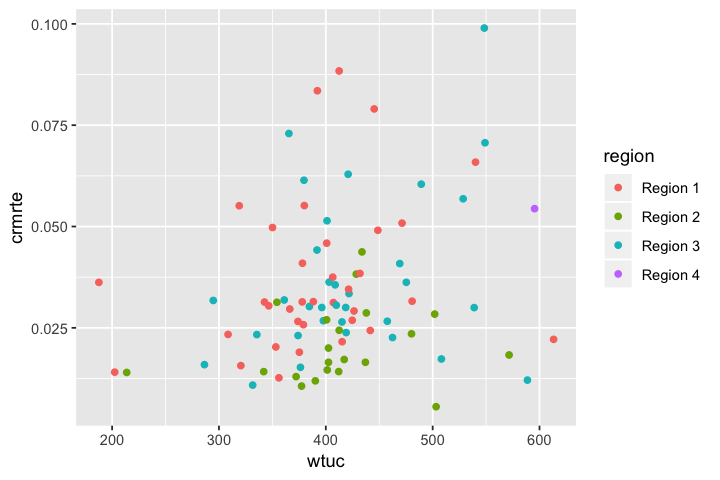

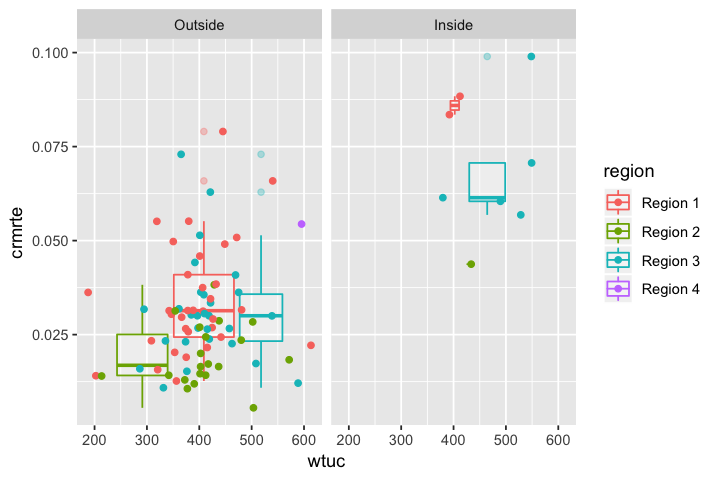

In [17]:
#ggplot(data = dfCrime, aes(x = density, y = crmidx, color = region)) +
#  geom_point()

ggplot(data = dfCrime, aes(x = wtuc, y = crmrte, color = region)) +
  geom_point()

ggplot(data = dfCrime, 
       aes(x = wtuc, y = crmrte, color=region)) +
  geom_boxplot(alpha=.3) + geom_jitter(position=position_jitter(0.2)) + facet_wrap(~ metro)


In [18]:
#options(repr.plot.width=6, repr.plot.height=4)
#ggplot(dfCrime, aes( x=crmrte,  color=region, fill = region)) + 
#  geom_histogram(position="identity", bins=30, alpha=0.4) +
#  labs(title="Crime Rate Frequency")

In [19]:
#Survey Design package experimentation

In [20]:
#Create a survey design from our data
crime_design = svydesign(ids=dfCrime$county, data=dfCrime)

#Include the relevent questions in our design object for analysis preparation
crime_design <- 
    update( 
        crime_design ,     
        one = 1)

Warning message in svydesign.default(ids = dfCrime$county, data = dfCrime):
“No weights or probabilities supplied, assuming equal probability”

In [21]:
summary(crime_design)
str(crime_design)

Independent Sampling design (with replacement)
update(crime_design, one = 1)
Probabilities:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 
Data variables:
 [1] "county"   "year"     "crmrte"   "prbarr"   "prbconv"  "prbpris" 
 [7] "avgsen"   "polpc"    "density"  "taxpc"    "west"     "central" 
[13] "urban"    "pctmin80" "wcon"     "wtuc"     "wtrd"     "wfir"    
[19] "wser"     "wmfg"     "wfed"     "wsta"     "wloc"     "mix"     
[25] "pctymle"  "region"   "metro"    "crmidx"   "one"     

List of 9
 $ cluster   :'data.frame':	90 obs. of  1 variable:
  ..$ ids: Factor w/ 90 levels "1","3","5","7",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ strata    :'data.frame':	90 obs. of  1 variable:
  ..$ V1: num [1:90] 1 1 1 1 1 1 1 1 1 1 ...
 $ has.strata: logi FALSE
 $ prob      : num [1:90] 1 1 1 1 1 1 1 1 1 1 ...
 $ allprob   :'data.frame':	90 obs. of  1 variable:
  ..$ probs: num [1:90] 1 1 1 1 1 1 1 1 1 1 ...
 $ call      : language update(crime_design, one = 1)
 $ variables :'data.frame':	90 obs. of  29 variables:
  ..$ county  : Factor w/ 90 levels "1","3","5","7",..: 1 2 3 4 5 6 7 8 9 10 ...
  ..$ year    : int [1:90] 87 87 87 87 87 87 87 87 87 87 ...
  ..$ crmrte  : num [1:90] 0.0356 0.0153 0.013 0.0268 0.0106 ...
  ..$ prbarr  : num [1:90] 0.298 0.132 0.444 0.365 0.518 ...
  ..$ prbconv : num [1:90] 0.528 1.481 0.268 0.525 0.477 ...
  ..$ prbpris : num [1:90] 0.436 0.45 0.6 0.435 0.443 ...
  ..$ avgsen  : num [1:90] 6.71 6.35 6.76 7.14 8.22 ...
  ..$ polpc   : num [1:90] 0.001828 0.

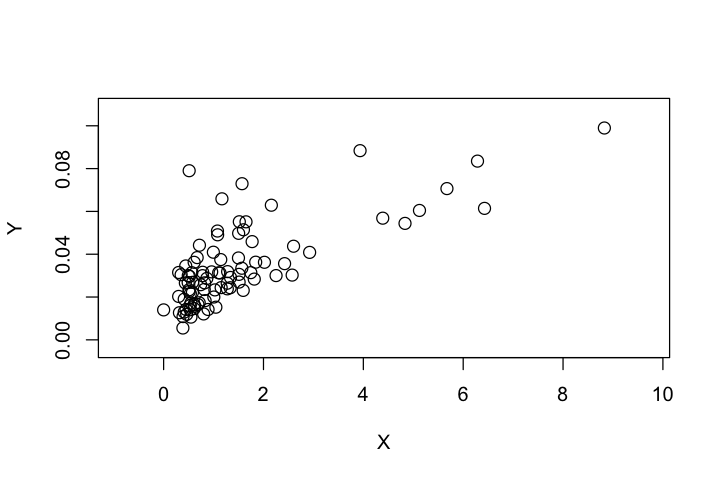

In [22]:
svyplot(crmrte ~density, design= crime_design)

In [23]:
crimeStats<-svyby(~crmrte+year+prbarr+prbconv+prbpris+avgsen+polpc+density+taxpc+west+central+urban+pctmin80+wcon+wtuc+wtrd+wfir+wser+wmfg+wfed+wsta+wloc+mix+pctymle, ~county, design=crime_design, svytotal, keep.names=FALSE)

In [24]:
crimeStats %>% filter(density>2) %>% arrange(desc(crmrte))

county,crmrte,year,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,⋯,se.wtuc,se.wtrd,se.wfir,se.wser,se.wmfg,se.wfed,se.wsta,se.wloc,se.mix,se.pctymle
119,0.0989659,87,0.149094,0.347800,0.486183,7.13,0.00223135,8.827652,75.67243,⋯,548.3239,354.6761,509.4655,354.3007,494.30,568.40,329.22,379.77,0.16869897,0.07916495
51,0.0883849,87,0.155248,0.259833,0.407628,11.93,0.00190802,3.934551,35.69936,⋯,412.4720,213.7524,324.8357,257.3344,441.72,433.94,367.34,333.71,0.10474319,0.14223780
129,0.0834982,87,0.236601,0.393413,0.415158,9.57,0.00255849,6.286487,67.67963,⋯,392.0999,220.4530,363.2880,292.7027,464.49,548.49,421.36,319.08,0.07871422,0.08109921
63,0.0706599,87,0.133225,0.459216,0.363636,11.51,0.00237609,5.674497,50.19918,⋯,548.9865,238.9154,435.1107,391.3081,646.85,563.77,415.51,362.58,0.07585382,0.09468981
135,0.0628972,87,0.092770,0.477733,0.385593,11.92,0.00233871,2.157500,35.99248,⋯,420.8830,179.1289,389.8522,292.2253,388.75,509.95,499.59,333.05,0.05091770,0.13302912
67,0.0614177,87,0.217215,0.248276,0.488426,10.57,0.00217747,6.427185,45.89987,⋯,379.5547,189.1807,278.0352,230.4981,275.72,419.07,400.59,313.55,0.21999694,0.07647973
81,0.0604498,87,0.300215,0.203725,0.431020,14.42,0.00243562,5.124424,44.21059,⋯,489.3144,308.5762,420.8864,305.1543,448.86,563.72,426.47,333.64,0.10255422,0.08310476
183,0.0568423,87,0.204216,0.381908,0.367347,12.15,0.00212751,4.388759,48.76492,⋯,528.5593,306.0835,430.0697,348.2754,444.45,597.95,453.08,362.99,0.08527010,0.09935585
71,0.0544061,87,0.243119,0.229590,0.379175,11.29,0.00207028,4.834734,31.53658,⋯,595.3719,240.3673,348.0254,295.2301,358.95,509.43,359.11,339.58,0.10186080,0.07939028
21,0.0437355,87,0.234760,0.334701,0.429072,10.62,0.00182958,2.602428,52.62629,⋯,433.8580,228.1740,363.7671,318.3635,378.90,496.13,381.30,335.36,0.06289308,0.07219726


In [25]:
### corrplot

In [26]:
library(corrplot)
x <- cor(dfCrime, use = "complete.obs")
corrplot(x, method='circle')

corrplot 0.84 loaded


ERROR: Error in cor(dfCrime, use = "complete.obs"): 'x' must be numeric


In [27]:
### dataexplorer

In [28]:
#install.packages("DataExplorer")

In [29]:
library(DataExplorer)

In [30]:
config <- list(
  "introduce" = list(),
  "plot_str" = list(
    "type" = "diagonal",
    "fontSize" = 35,
    "width" = 1000,
    "margin" = list("left" = 350, "right" = 250)
  ),
  "plot_missing" = list(),
  "plot_histogram" = list(),
  "plot_qq" = list(sampled_rows = 1000L),
  "plot_bar" = list(),
  "plot_correlation" = list("cor_args" = list("use" = "pairwise.complete.obs")),
#  "plot_prcomp" = list(),
  "plot_boxplot" = list(),
  "plot_scatterplot" = list(sampled_rows = 1000L)
)

In [31]:
create_report(dfCrime, config=config)



processing file: report.rmd


  |..                                                               |   2%
   inline R code fragments

  |...                                                              |   5%
label: global_options (with options) 
List of 1
 $ include: logi FALSE

  |.....                                                            |   7%
  ordinary text without R code

  |......                                                           |  10%
label: introduce
  |........                                                         |  12%
  ordinary text without R code

  |.........                                                        |  14%
label: plot_intro
  |...........                                                      |  17%
  ordinary text without R code

  |............                                                     |  19%
label: data_structure
  |..............                                                   |  21%
  ordinary text without R code

  |...............                      

output file: /Users/kevin/Documents/GitHub/MIDS_W203_5_Lab3/report.knit.md



/Users/kevin/anaconda3/bin/pandoc +RTS -K512m -RTS /Users/kevin/Documents/GitHub/MIDS_W203_5_Lab3/report.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash --output /Users/kevin/Documents/GitHub/MIDS_W203_5_Lab3/report.html --smart --email-obfuscation none --self-contained --standalone --section-divs --table-of-contents --toc-depth 6 --template /Users/kevin/anaconda3/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:yeti' --include-in-header /var/folders/q8/4bswy_qj0156rc11h3f8q2dm0000gn/T//Rtmp0wO8N5/rmarkdown-str1080c2b856575.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: report.html


Report is generated at "/Users/kevin/Documents/GitHub/MIDS_W203_5_Lab3/report.html".


In [ ]:
## Miscelleanous

In [80]:
tab_r<-svytable(~county+region, crime_design)
tab_r <- as.data.frame(tab_r) %>%
  group_by(county) %>%
  mutate(n_Category = sum(Freq), Prop_county = Freq / n_Category) %>%
  ungroup()
tab_r <- tab_r %>% rename(Region=region)

In [81]:
tab_c<-svyby(~crmidx, ~county, crime_design, svytotal)

In [82]:
tab_u<-svytable(~county+metro, crime_design)
tab_u <- as.data.frame(tab_u) %>%
  group_by(county) %>%
  mutate(n_Category = sum(Freq), Prop_county = Freq / n_Category) %>%
  ungroup()

In [90]:
df2<-data.frame(cbind(dfCrime$county, dfCrime$crmrte, tab_c %>% select(crmidx), dfCrime$density, tab_u %>% filter(Freq!=0) %>% arrange(county) %>% select(metro), dfCrime$west, dfCrime$central, tab_r %>% filter(Freq!=0) %>% arrange(county) %>% select(Region)))
names(df2)<-c("county", "crmrte", "crmidx", "density", "metro", "western", "central", "region")
df2 %>% filter(density>2) %>% arrange(desc(crmrte))

county,crmrte,crmidx,density,metro,western,central,region
119,0.0989659,87.363651,8.827652,Inside,0,1,Region 3
51,0.0883849,34.775488,3.934551,Inside,0,0,Region 1
129,0.0834982,52.491033,6.286487,Inside,0,0,Region 1
63,0.0706599,40.095935,5.674497,Inside,0,1,Region 3
135,0.0628972,13.570071,2.157500,Outside,0,1,Region 3
67,0.0614177,39.474289,6.427185,Inside,0,1,Region 3
81,0.0604498,30.977041,5.124424,Inside,0,1,Region 3
183,0.0568423,24.946714,4.388759,Inside,0,1,Region 3
71,0.0544061,26.303901,4.834734,Outside,1,1,Region 4
21,0.0437355,11.381849,2.602428,Inside,1,0,Region 2


In [76]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
dfCrime %>%
filter(county %in% 65:90) 

county,year,crmrte,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle
65,87,0.0658801,0.287330,0.154452,0.403922,9.84,0.00185739,1.1679842,30.62824,0,0,0,51.69320,362.1527,540.1061,209.0579,316.2955,216.4589,313.71,543.03,348.88,329.16,0.09364294,0.07622346
67,87,0.0614177,0.217215,0.248276,0.488426,10.57,0.00217747,6.4271846,45.89987,0,1,1,25.65460,206.5527,379.5547,189.1807,278.0352,230.4981,275.72,419.07,400.59,313.55,0.21999694,0.07647973
69,87,0.0173158,0.283505,0.739394,0.418033,9.10,0.00107108,0.7125506,35.37642,0,1,0,42.32240,372.1622,508.2035,266.7794,466.0016,347.6609,560.78,516.05,381.03,388.09,0.07977737,0.08181948
71,87,0.0544061,0.243119,0.229590,0.379175,11.29,0.00207028,4.8347340,31.53658,1,1,0,13.31500,291.4508,595.3719,240.3673,348.0254,295.2301,358.95,509.43,359.11,339.58,0.10186080,0.07939028
77,87,0.0441957,0.190876,0.528302,0.488095,9.60,0.00246711,0.7172285,29.70588,0,1,0,45.45130,254.7925,391.7379,197.6995,311.3553,199.4458,360.21,512.30,369.75,329.34,0.17905165,0.08345764
79,87,0.0156759,0.411538,0.308411,0.454545,6.19,0.00102496,0.6203008,37.50189,0,0,0,45.46750,223.9199,320.5128,171.0329,334.4482,250.0000,218.30,353.31,385.19,323.08,0.28078818,0.08120255
81,87,0.0604498,0.300215,0.203725,0.431020,14.42,0.00243562,5.1244240,44.21059,0,1,1,26.39410,404.8150,489.3144,308.5762,420.8864,305.1543,448.86,563.72,426.47,333.64,0.10255422,0.08310476
83,87,0.0315752,0.456394,0.457210,0.410256,7.85,0.00138532,0.7817680,41.08650,0,0,0,50.56250,269.1710,480.7692,200.3768,297.2437,239.2233,360.27,466.61,367.24,302.63,0.09106830,0.07521905
85,87,0.0490712,0.146132,0.549020,0.428571,8.78,0.00143730,1.0815308,27.16143,0,0,0,25.62870,245.8896,448.7180,198.6254,248.1390,264.6729,310.86,437.03,397.54,327.37,0.14886613,0.10694169
87,87,0.0286781,0.215108,0.548495,0.341463,11.11,0.00169180,0.8648649,32.82694,1,0,0,2.69921,250.7271,437.9284,196.5065,288.4615,243.4706,588.99,488.76,346.32,294.21,0.09794629,0.07600891


In [1]:

#create a cross-table for plotting
tab_r<-svytable(~county+region, crime_design)
tab_u<-svytable(~county+urban, crime_design)
tab_d<-svytable(~county+density, crime_design)

tab_r <- as.data.frame(tab_r) %>%
  group_by(county) %>%
  mutate(n_Category = sum(Freq), Prop_county = Freq / n_Category) %>%
  ungroup()
tab_r <- tab_r %>% rename(Region=region)

tab_u <- as.data.frame(tab_u) %>%
  group_by(county) %>%
  mutate(n_Category = sum(Freq), Prop_county = Freq / n_Category) %>%
  ungroup()
tab_u <- tab_u %>% rename(Urban=urban)

tab_d <- as.data.frame(tab_d) %>%
  group_by(county) %>%
  mutate(n_Category = sum(Freq), Prop_county = Freq / n_Category) %>%
  ungroup()
tab_d <- tab_d %>% rename(Density=density)

length(tab_r$county)
length(tab_u$county)


ERROR: Error in svytable(~county + region, crime_design): could not find function "svytable"


In [243]:
svyby(~density+urban+west+central+region, ~county, design=crime_design, svytotal, keep.names=FALSE)

county,density,urban,west,central,regionRegion 1,regionRegion 2,regionRegion 3,regionRegion 4,se.density,se.urban,se.west,se.central,se.regionRegion 1,se.regionRegion 2,se.regionRegion 3,se.regionRegion 4
1,2.4226326940,0,0,1,0,0,1,0,2.4226326940,0,0,1,0,0,1,0
3,1.0463320020,0,0,1,0,0,1,0,1.0463320020,0,0,1,0,0,1,0
5,0.4127659500,0,1,0,0,1,0,0,0.4127659500,0,1,0,0,1,0,0
7,0.4915572110,0,0,1,0,0,1,0,0.4915572110,0,0,1,0,0,1,0
9,0.5469483730,0,1,0,0,1,0,0,0.5469483730,0,1,0,0,1,0,0
11,0.6113360520,0,1,0,0,1,0,0,0.6113360520,0,1,0,0,1,0,0
13,0.5169491770,0,0,0,1,0,0,0,0.5169491770,0,0,0,1,0,0,0
15,0.3009985690,0,0,0,1,0,0,0,0.3009985690,0,0,0,1,0,0,0
17,0.3503981830,0,0,0,1,0,0,0,0.3503981830,0,0,0,1,0,0,0
19,0.5767441990,0,0,0,1,0,0,0,0.5767441990,0,0,0,1,0,0,0


In [244]:
crimeStats<-svyby(~crmidx+year+prbarr+prbconv+prbpris+avgsen+polpc+density+taxpc+west+central+urban+pctmin80+wcon+wtuc+wtrd+wfir+wser+wmfg+wfed+wsta+wloc+mix+pctymle, ~county, design=crime_design, svytotal, keep.names=FALSE)

In [245]:
crimeStats

county,crmidx,year,prbarr,prbconv,prbpris,avgsen,polpc,density,taxpc,west,central,urban,pctmin80,wcon,wtuc,wtrd,wfir,wser,wmfg,wfed,wsta,wloc,mix,pctymle,se.crmidx,se.year,se.prbarr,se.prbconv,se.prbpris,se.avgsen,se.polpc,se.density,se.taxpc,se.west,se.central,se.urban,se.pctmin80,se.wcon,se.wtuc,se.wtrd,se.wfir,se.wser,se.wmfg,se.wfed,se.wsta,se.wloc,se.mix,se.pctymle
1,8.625445e+00,87,0.298270,0.5275960,0.436170,6.71,0.00182786,2.4226326940,30.99368,0,1,0,0.2021870,281.4259,408.7245,221.2701,453.1722,274.1775,334.54,477.58,292.09,311.91,0.08016878,0.07787097,8.625445e+00,87,0.298270,0.5275960,0.436170,6.71,0.00182786,2.4226326940,30.99368,0,1,0,0.2021870,281.4259,408.7245,221.2701,453.1722,274.1775,334.54,477.58,292.09,311.91,0.08016878,0.07787097
3,1.595991e+00,87,0.132029,1.4814800,0.450000,6.35,0.00074588,1.0463320020,26.89208,0,1,0,0.0791632,255.1020,376.2542,196.0101,258.5650,192.3077,300.38,409.83,362.96,301.47,0.03022670,0.08260694,1.595991e+00,87,0.132029,1.4814800,0.450000,6.35,0.00074588,1.0463320020,26.89208,0,1,0,0.0791632,255.1020,376.2542,196.0101,258.5650,192.3077,300.38,409.83,362.96,301.47,0.03022670,0.08260694
5,5.349571e-01,87,0.444444,0.2678570,0.600000,6.76,0.00123431,0.4127659500,34.81605,1,0,0,0.0316053,226.9470,372.2084,229.3209,305.9441,209.6972,237.65,358.98,331.53,281.37,0.46511629,0.07211538,5.349571e-01,87,0.444444,0.2678570,0.600000,6.76,0.00123431,0.4127659500,34.81605,1,0,0,0.0316053,226.9470,372.2084,229.3209,305.9441,209.6972,237.65,358.98,331.53,281.37,0.46511629,0.07211538
7,1.315073e+00,87,0.364760,0.5254240,0.435484,7.14,0.00152994,0.4915572110,42.94759,0,1,0,0.4791610,375.2345,397.6901,191.1720,281.0651,256.7214,281.80,412.15,328.27,299.03,0.27362204,0.07353726,1.315073e+00,87,0.364760,0.5254240,0.435484,7.14,0.00152994,0.4915572110,42.94759,0,1,0,0.4791610,375.2345,397.6901,191.1720,281.0651,256.7214,281.80,412.15,328.27,299.03,0.27362204,0.07353726
9,5.810342e-01,87,0.518219,0.4765630,0.442623,8.22,0.00086018,0.5469483730,28.05474,1,0,0,0.0179619,292.3077,377.3126,206.8215,289.3125,215.1933,290.89,377.35,367.23,342.82,0.06008584,0.07069755,5.810342e-01,87,0.518219,0.4765630,0.442623,8.22,0.00086018,0.5469483730,28.05474,1,0,0,0.0179619,292.3077,377.3126,206.8215,289.3125,215.1933,290.89,377.35,367.23,342.82,0.06008584,0.07069755
11,8.929602e-01,87,0.524664,0.0683761,0.500000,13.00,0.00288203,0.6113360520,35.22974,1,0,0,0.0154070,250.4006,401.3378,187.8255,258.5650,237.1507,258.60,391.48,325.71,275.22,0.31952664,0.09891920,8.929602e-01,87,0.524664,0.0683761,0.500000,13.00,0.00288203,0.6113360520,35.22974,1,0,0,0.0154070,250.4006,401.3378,187.8255,258.5650,237.1507,258.60,391.48,325.71,275.22,0.31952664,0.09891920
13,1.532284e+00,87,0.365004,0.5206070,0.420833,10.55,0.00133771,0.5169491770,30.69649,0,0,0,0.3217940,238.3064,366.3004,205.5358,310.1737,259.3391,303.42,449.84,350.72,283.76,0.15237226,0.07073344,1.532284e+00,87,0.365004,0.5206070,0.420833,10.55,0.00133771,0.5169491770,30.69649,0,0,0,0.3217940,238.3064,366.3004,205.5358,310.1737,259.3391,303.42,449.84,350.72,283.76,0.15237226,0.07073344
15,6.104673e-01,87,0.392111,0.7692310,0.507692,10.64,0.00103525,0.3009985690,34.00304,0,0,0,0.6105400,253.5926,353.2182,199.2377,356.1254,206.2816,235.05,416.49,370.62,297.13,0.23495702,0.07430546,6.104673e-01,87,0.392111,0.7692310,0.507692,10.64,0.00103525,0.3009985690,34.00304,0,0,0,0.6105400,253.5926,353.2182,199.2377,356.1254,206.2816,235.05,416.49,370.62,297.13,0.23495702,0.07430546
17,1.066223e+00,87,0.251599,0.4364410,0.436893,7.32,0.00129761,0.3503981830,34.96204,0,0,0,0.4038900,193.6432,346.6011,202.9595,268.3363,208.2520,339.76,389.51,322.06,278.39,0.21818182,0.07769163,1.066223e+00,87,0.251599,0.4364410,0.436893,7.32,0.00129761,0.3503981830,34.96204,0,0,0,0.4038900,193.6432,346.6011,202.9595,268.3363,208.2520,339.76,389.51,322.06,278.39,0.21818182,0.07769163
19,1.277875e+00,87,0.162860,1.2256100,0.333333,10.34,0.00202425,0.5767441990,61.15251,0,0,0,0.2431170,260.1381,613.2261,191.2

In [398]:
df<-svyby(~crmidx, ~density+region+urban, design=crime_design, svytotal ) %>% as.data.frame()

In [25]:
install.packages("corrplot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [ ]:
library(corrplot)
A$prbconv <- as.numeric(A$prbconv)
x <- cor(A, use = "complete.obs")
corrplot(x, method='circle')

In [100]:
#Create a survey design from our data
crime_design = svydesign(ids=dfCrime$county, data=dfCrime)

#Include the relevent questions in our design object for analysis preparation
crime_design <- 
    update( 
        crime_design ,     
        one = 1,
        region = case_when (
            (central ==0 & west ==0) ~ 0, #Eastern, Coastal, Other
            (central ==0 & west ==1) ~ 1, #Western
            (central ==1 & west ==0) ~ 2, #Central
            (central ==1 & west ==1) ~ 3, #Central-Western border county - this could be Charlotte or it could be an error.
        ),
        # create a factor for 'central', 'western', 'central/western' and 'eastern, coastal, other' region
        region =
            factor( region , levels = 0:3 , labels =
                    c( 'Region 1',
                       'Region 2',
                       'Region 3',
                       'Region 4'
                      )
                   ),
        # create factor for SMSA (standard metropolitan statistical areas) with two levels - inside or outside
        #    https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu8011uns_bw.pdf
        metro =
            factor( urban , levels = 0:1 , labels =
                    c( 'Outside',
                       'Inside'
                      )
                   ),
        
        # create a crime index (number of crimes per square mile in the county) to remove causal effects with the population density
        #   crmrte = crimes committed per person
        #   density = people per sq. mile, in 100s (through analysis with our EDA and confirmation on US census 1980 report)
        crmidx = crmrte * density * 100, # crimes per square mile of land mass in the county
        
        # create a revenue index (number of dollars per square mile in the county) to remove effects of the population density
        #   taxpc = tax renenue per capita (per person)
        revidx = taxpc * density * 100, # tax revenue per square mile of land mass in the county
        ymleidx = pctymle * density * 100, # number of young men ages 15-24 per square mile in the county
        minidx = pctmin80 * density * 100, # number of minorities per square mile in the county
        polidx = polpc * density * 100, # number of police per square mile in the county
        # prbarr = arrests / offenses
        # prbconv = convictions / arrests
        # prbpris = prison / convictions
        # prbcrime =
        
        
        # for the weekly wages and pctymle
        # https://www2.census.gov/prod2/decennial/documents/1980/1980censusofpopu801352uns_bw.pdf
)

Warning message in svydesign.default(ids = dfCrime$county, data = dfCrime):
“No weights or probabilities supplied, assuming equal probability”